In [1]:
from __future__ import print_function
from __future__ import absolute_import
from classes.Sampler import *
from classes.model.pix2code import *
from os.path import basename

모델 로드

In [2]:
trained_weights_path = '../bin'
trained_model_name = 'pix2code'
output_path = '../code'
input_path = './test.png'
meta_dataset = np.load("{}/meta_dataset.npy".format(trained_weights_path), allow_pickle=True)
input_shape = meta_dataset[0]
output_size = meta_dataset[1]

model = pix2code(input_shape, output_size, trained_weights_path)
model.load(trained_model_name)

sampler = Sampler(trained_weights_path, input_shape, output_size, CONTEXT_LENGTH)

c:\dev\anaconda3\envs\capstone\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Vocabulary size: 19
Input shape: (256, 256, 3)
Output size: 19


모델 쪼개기

In [3]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 48, 19)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 48, 1024)     104098080   ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 48, 128)      207360      ['input_2[0][0]']            

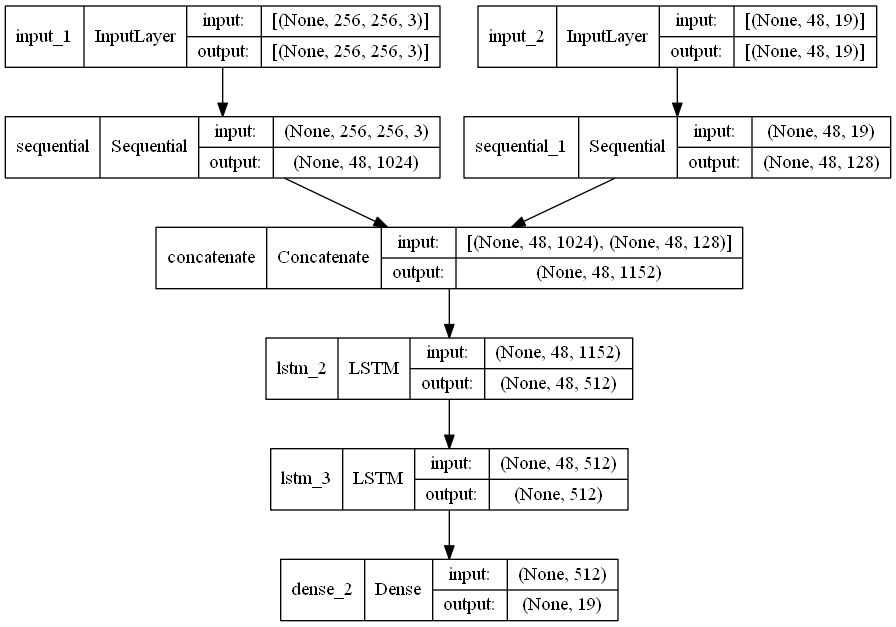

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model.model, to_file='mod.png', show_shapes=True)

이미지 모델

In [5]:
test_img = Utils.get_preprocessed_img(input_path, IMAGE_SIZE)

In [6]:
visual_input = model.model.get_layer('input_1').output
cnn = model.model.get_layer('sequential')(visual_input)
image_model = Model(visual_input, cnn)


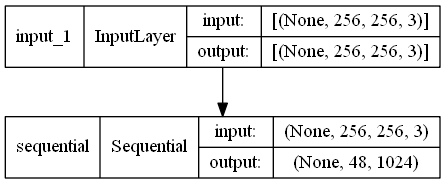

In [7]:
plot_model(image_model, to_file='mod.png', show_shapes=True)

In [8]:
encoded_image = image_model.predict(np.array([test_img]))

In [9]:
print(encoded_image)

[[[0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]
  [0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]
  [0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]
  ...
  [0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]
  [0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]
  [0.03078072 0.00121635 0.         ... 0.         0.00261119 0.00803554]]]


텍스트 모델

In [10]:
encoded_image_input = Input(shape=(48,1024))
textual_input = model.model.get_layer('input_2')
encoded_text = model.model.get_layer('sequential_1')(textual_input.output)
decoder = concatenate([encoded_image_input, encoded_text])
decoder = model.model.get_layer('lstm_2')(decoder)
decoder = model.model.get_layer('lstm_3')(decoder)
decoder = model.model.get_layer('dense_2')(decoder)
textual_model = Model(inputs=[encoded_image_input, textual_input.output], outputs=decoder)
# splited_model = Model(inputs=[encoded_image, textual_input])

In [11]:
textual_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 19)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 48, 1024)]   0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 48, 128)      207360      ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 48, 1152)     0           ['input_3[0][0]',                
                                                                  'sequential_1[1][0]']     

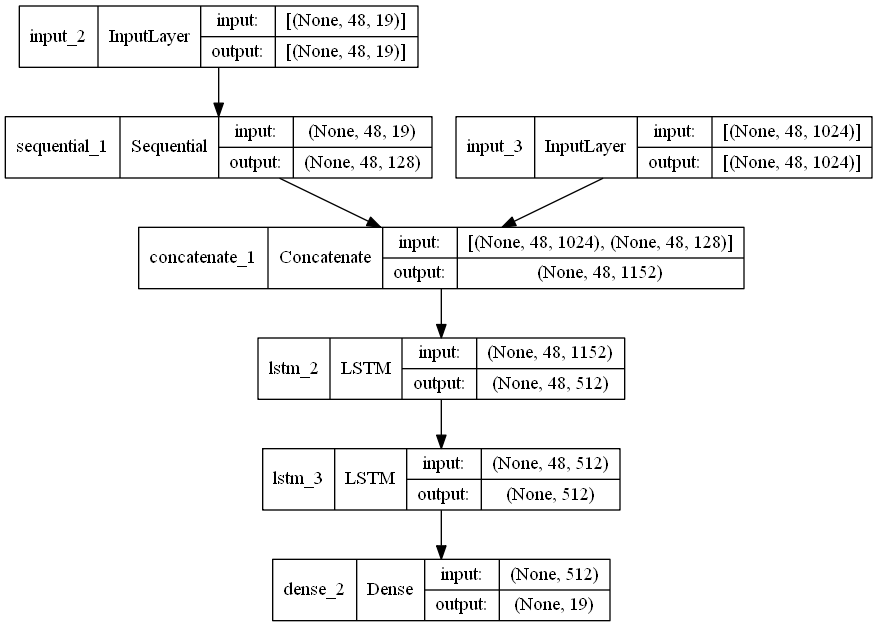

In [12]:
plot_model(textual_model, to_file='mod.png', show_shapes=True)

In [13]:
class SplitedSampler:
    def __init__(self, voc_path, input_shape, output_size, context_length):
        self.voc = Vocabulary()
        self.voc.retrieve(voc_path)

        self.input_shape = input_shape
        self.output_size = output_size

        print("Vocabulary size: {}".format(self.voc.size))
        print("Input shape: {}".format(self.input_shape))
        print("Output size: {}".format(self.output_size))

        self.context_length = context_length

    def predict_greedy(self, model, input_img, require_sparse_label=True, sequence_length=150, verbose=False):
        current_context = [self.voc.vocabulary[PLACEHOLDER]] * (self.context_length - 1)
        current_context.append(self.voc.vocabulary[START_TOKEN])
        if require_sparse_label:
            current_context = Utils.sparsify(current_context, self.output_size)

        predictions = START_TOKEN
        out_probas = []

        for i in range(0, sequence_length):
            if verbose:
                print("predicting {}/{}...".format(i, sequence_length))
                
            probas = model.predict([input_img, np.array([current_context])])[0]
            prediction = np.argmax(probas)
            out_probas.append(probas)

            new_context = []
            for j in range(1, self.context_length):
                new_context.append(current_context[j])

            if require_sparse_label:
                sparse_label = np.zeros(self.output_size)
                sparse_label[prediction] = 1
                new_context.append(sparse_label)
            else:
                new_context.append(prediction)

            current_context = new_context

            predictions += self.voc.token_lookup[prediction]

            if self.voc.token_lookup[prediction] == END_TOKEN:
                break

        return predictions, out_probas

In [14]:
splSampler = SplitedSampler(trained_weights_path, input_shape, output_size, CONTEXT_LENGTH)
file_name = basename(input_path)[:basename(input_path).find(".")]
result, _ = splSampler.predict_greedy(textual_model, encoded_image)

Vocabulary size: 19
Input shape: (256, 256, 3)
Output size: 19


In [15]:
print(result)

<START>header{
btn-inactive,btn-inactive,btn-inactive,btn-active
}
row{
single{
small-title,text,btn-red
}
}
<END>
